In [47]:
import seaborn as sns
import pylab as rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib 
import pandas as pd 
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from sklearn.preprocessing import MinMaxScaler
from  sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping
import tensorflow as tf
import keras_tuner as kt

In [48]:
df=pd.read_csv('/home/j/usfq/tesis/StockPredictionModels/Data/Complete.csv')
df

,Date,ticker_symbol,p_sentiment,Open,High,Low,Close,Volume,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,AAPL,0.766185,27.847500,27.860001,26.837500,27.332500,212818400,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
1,2015-01-02,AMZN,0.506131,15.629000,15.737500,15.348000,15.426000,55664000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
2,2015-01-02,GOOG,0.846197,26.378078,26.490770,26.133251,26.168653,28951268,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
3,2015-01-02,GOOGL,0.819823,26.629999,26.790001,26.393999,26.477501,26480000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
4,2015-01-02,MSFT,0.795557,46.660000,47.419998,46.540001,46.759998,27913900,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7539,2019-12-31,AMZN,0.715115,92.099998,92.663002,91.611504,92.391998,50130000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7540,2019-12-31,GOOG,0.656211,66.505501,66.900002,66.454247,66.850998,19236000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7541,2019-12-31,GOOGL,0.777357,66.789497,67.032997,66.606499,66.969498,19514000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7542,2019-12-31,MSFT,0.683018,156.770004,157.770004,156.449997,157.699997,18369400,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651


In [49]:
#turn date into unix time
#df['Date'] = pd.to_datetime(df['Date'])
#df['Date'] = df['Date'].apply(lambda x: x.timestamp())
#df

In [50]:
#generate new dataframes for each ticker_symbol
df_dict={}
for key in df['ticker_symbol'].unique():
    df_dict[key]=df[df['ticker_symbol']==key]
    df_dict[key]=df_dict[key].drop(columns=['ticker_symbol'])
    df_dict[key]=df_dict[key].sort_values(by=['Date']).reset_index(drop=True)
    #df_dict[key]=df_dict[key].drop(columns=['Date'])
    print(key,df_dict[key].shape)
    print(df_dict[key].head(-1))

AAPL (1254, 18)
            Date  p_sentiment       Open       High        Low      Close  \
0     2015-01-02     0.766185  27.847500  27.860001  26.837500  27.332500   
1     2015-01-05     0.846650  27.072500  27.162500  26.352501  26.562500   
2     2015-01-06     0.712894  26.635000  26.857500  26.157499  26.565001   
3     2015-01-07     0.744531  26.799999  27.049999  26.674999  26.937500   
4     2015-01-08     0.769826  27.307501  28.037500  27.174999  27.972500   
...          ...          ...        ...        ...        ...        ...   
1248  2019-12-23     0.761074  70.132500  71.062500  70.092499  71.000000   
1249  2019-12-24     0.775495  71.172501  71.222504  70.730003  71.067497   
1250  2019-12-26     0.742264  71.205002  72.495003  71.175003  72.477501   
1251  2019-12-27     0.768797  72.779999  73.492500  72.029999  72.449997   
1252  2019-12-30     0.746877  72.364998  73.172501  71.305000  72.879997   

         Volume  unrate  psr       m2    dspic      pce    

In [51]:
ticker='TSLA'

In [52]:
df=df_dict[ticker].copy()
df.head()

,Date,p_sentiment,Open,High,Low,Close,Volume,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,0.710122,14.858000,14.883333,14.217333,14.620667,71466000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
1,2015-01-05,0.728551,14.303333,14.433333,13.810667,14.006000,80527500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
2,2015-01-06,0.658187,14.004000,14.280000,13.614000,14.085333,93928500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
3,2015-01-07,0.646626,14.223333,14.318667,13.985333,14.063333,44526000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
4,2015-01-08,0.696584,14.187333,14.253333,14.000667,14.041333,51637500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811


In [53]:
#putting the close column on the last position
df=df[['Date', 'p_sentiment', 'Open', 'High', 'Low',
       'Volume', 'unrate', 'psr', 'm2', 'dspic', 'pce', 'reer', 'ir', 'ffer',
       'tcs', 'indpro', 'ccpi', 'Close']]

In [54]:
dates = pd.to_datetime(df['Date'])

In [55]:
cols=list(df)[1:]
cols

['p_sentiment',
 'Open',
 'High',
 'Low',
 'Volume',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
 'Close']

In [56]:
df_for_training = df[cols].astype(float)

In [57]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_for_training)

In [58]:
print(scaled_data)

[[0.73349331 0.27521525 0.24356139 ... 0.77924797 0.         0.26330631]
 [0.77183473 0.24678828 0.21948349 ... 0.77924797 0.         0.23121105]
 [0.62544497 0.23144731 0.21127918 ... 0.77924797 0.         0.23535347]
 ...
 [0.50389745 1.         1.         ... 0.57323507 1.         0.99805053]
 [0.30306162 0.97878229 0.97749165 ... 0.57323507 1.         0.9434678 ]
 [0.28882563 0.89749897 0.94998933 ... 0.57323507 1.         0.95610395]]


In [59]:
#split scaled data into training, val and testing
#train_data=scaled_data[0:1000,:]
#val_data=scaled_data[1000:1125,:]
#test_data=scaled_data[1125:,:]

In [60]:
n_future = 1 # Number of days we want to predict into the future
n_past = 7 # Number of past days we want to use to predict the future

In [61]:
X=[]
y=[]
for i in range(n_past, len(scaled_data) - n_future +1):
    X.append(scaled_data[i - n_past:i, 0:df_for_training.shape[1]])
    y.append(scaled_data[i + n_future - 1:i + n_future, len(cols)-1])

In [62]:
#shape of X_s and y_s
X, y = np.array(X), np.array(y)
print(X.shape)
print(y.shape)

(1251, 7, 17)
(1251, 1)


In [63]:
def build_model(hp):
    hp_units=hp.Int('units',min_value=2,max_value=240,step=2)
    model=Sequential()
    model.add(Bidirectional(LSTM(hp_units,activation='relu',input_shape=(X.shape[1],X.shape[2]),return_sequences=False)))
    model.add(Dense(y.shape[1]))
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),loss='mse')

    return model

early_stop=EarlyStopping(monitor='val_loss',patience=20)

In [64]:
tuner = kt.GridSearch(build_model,
                     objective='val_loss',
                     project_name='bi_lstm_tuning',
                     )

Reloading Tuner from ./bi_lstm_tuning/tuner0.json


In [65]:
tuner.search(X, y, epochs=1000, validation_split=0.2, callbacks=[early_stop])

In [66]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first LSTM layer is {best_hps.get('units')}.
""")


The hyperparameter search is complete. The optimal number of units in the first LSTM layer is 20.



Epoch 1/1000
3/3 [==============================] - 5s 200ms/step - loss: 0.0831 - val_loss: 0.3255
Epoch 2/1000
3/3 [==============================] - 0s 25ms/step - loss: 0.0785 - val_loss: 0.3147
Epoch 3/1000
3/3 [==============================] - 0s 37ms/step - loss: 0.0741 - val_loss: 0.3040
Epoch 4/1000
3/3 [==============================] - 0s 25ms/step - loss: 0.0698 - val_loss: 0.2936
Epoch 5/1000
3/3 [==============================] - 0s 23ms/step - loss: 0.0658 - val_loss: 0.2834
Epoch 6/1000
3/3 [==============================] - 0s 21ms/step - loss: 0.0619 - val_loss: 0.2735
Epoch 7/1000
3/3 [==============================] - 0s 19ms/step - loss: 0.0581 - val_loss: 0.2638
Epoch 8/1000
3/3 [==============================] - 0s 20ms/step - loss: 0.0546 - val_loss: 0.2545
Epoch 9/1000
3/3 [==============================] - 0s 19ms/step - loss: 0.0512 - val_loss: 0.2455
Epoch 10/1000
3/3 [==============================] - 0s 78ms/step - loss: 0.0480 - val_loss: 0.2367
Epoch 11

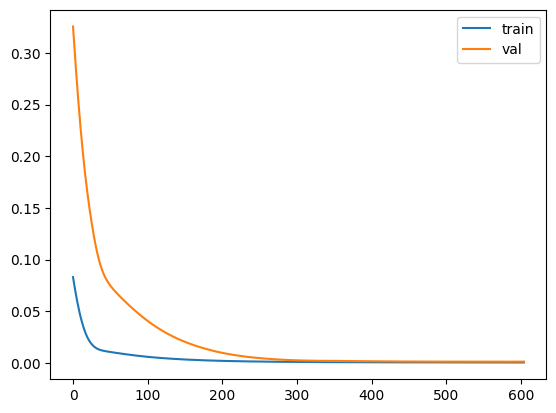

4/4 [==============================] - 0s 5ms/step
train mae: 0.9444255422514519
val mae: 0.5425341058203128


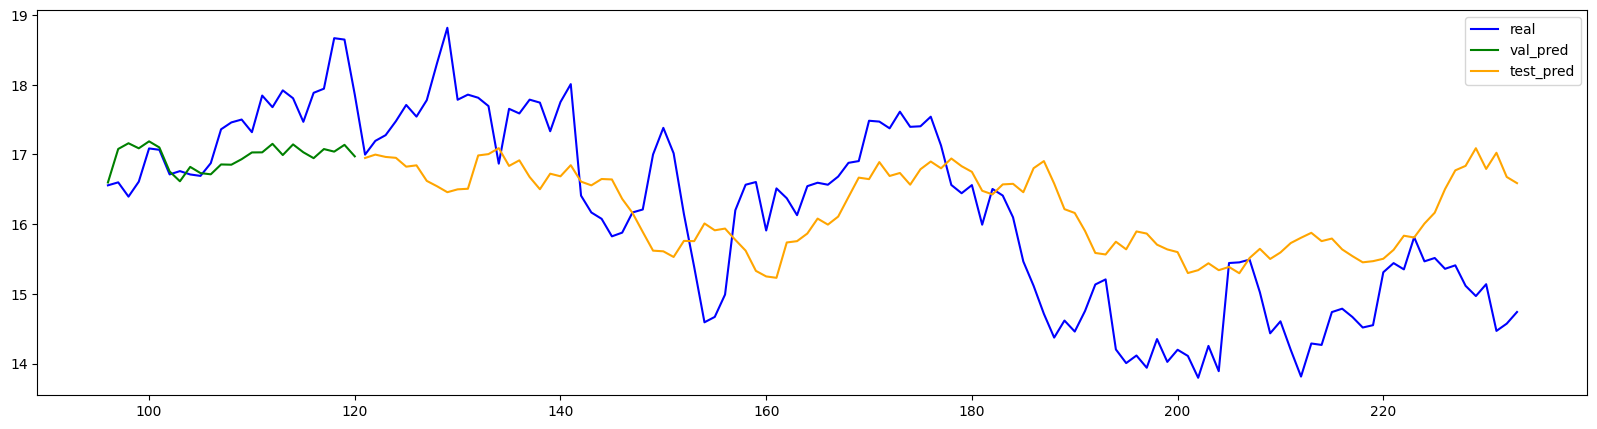

Epoch 1/1000
6/6 [==============================] - 2s 67ms/step - loss: 0.0615 - val_loss: 0.0148
Epoch 2/1000
6/6 [==============================] - 0s 45ms/step - loss: 0.0541 - val_loss: 0.0112
Epoch 3/1000
6/6 [==============================] - 0s 31ms/step - loss: 0.0473 - val_loss: 0.0082
Epoch 4/1000
6/6 [==============================] - 0s 32ms/step - loss: 0.0412 - val_loss: 0.0059
Epoch 5/1000
6/6 [==============================] - 0s 28ms/step - loss: 0.0358 - val_loss: 0.0042
Epoch 6/1000
6/6 [==============================] - 0s 26ms/step - loss: 0.0311 - val_loss: 0.0031
Epoch 7/1000
6/6 [==============================] - 0s 24ms/step - loss: 0.0271 - val_loss: 0.0025
Epoch 8/1000
6/6 [==============================] - 0s 25ms/step - loss: 0.0236 - val_loss: 0.0024
Epoch 9/1000
6/6 [==============================] - 0s 26ms/step - loss: 0.0207 - val_loss: 0.0026
Epoch 10/1000
6/6 [==============================] - 0s 25ms/step - loss: 0.0183 - val_loss: 0.0032
Epoch 11/

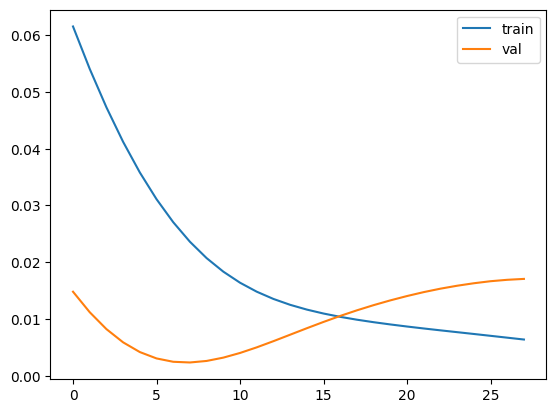

4/4 [==============================] - 0s 3ms/step
train mae: 2.9689595452319124
val mae: 2.3132718047784033


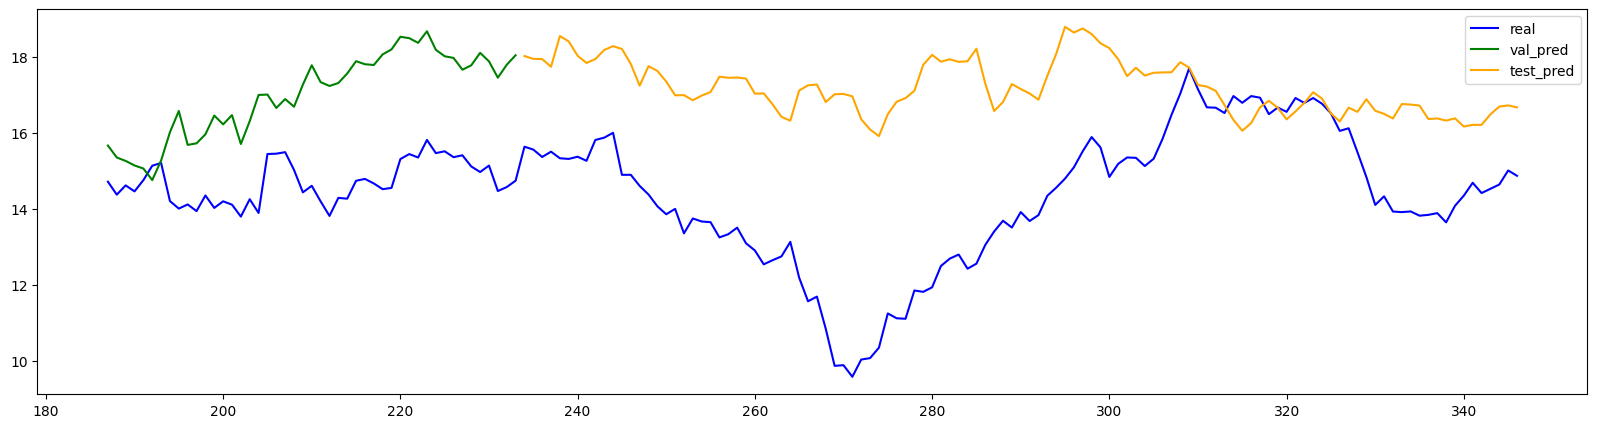

Epoch 1/1000
9/9 [==============================] - 1s 41ms/step - loss: 0.1035 - val_loss: 0.0348
Epoch 2/1000
9/9 [==============================] - 0s 26ms/step - loss: 0.0900 - val_loss: 0.0283
Epoch 3/1000
9/9 [==============================] - 0s 26ms/step - loss: 0.0782 - val_loss: 0.0228
Epoch 4/1000
9/9 [==============================] - 0s 25ms/step - loss: 0.0677 - val_loss: 0.0182
Epoch 5/1000
9/9 [==============================] - 0s 24ms/step - loss: 0.0584 - val_loss: 0.0145
Epoch 6/1000
9/9 [==============================] - 0s 25ms/step - loss: 0.0503 - val_loss: 0.0115
Epoch 7/1000
9/9 [==============================] - 0s 24ms/step - loss: 0.0432 - val_loss: 0.0092
Epoch 8/1000
9/9 [==============================] - 0s 25ms/step - loss: 0.0372 - val_loss: 0.0075
Epoch 9/1000
9/9 [==============================] - 0s 26ms/step - loss: 0.0320 - val_loss: 0.0063
Epoch 10/1000
9/9 [==============================] - 0s 25ms/step - loss: 0.0276 - val_loss: 0.0055
Epoch 11/

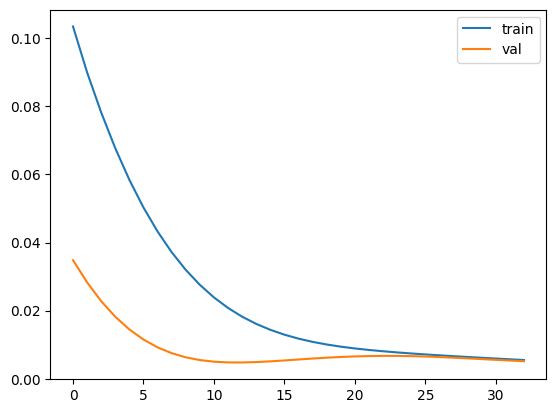

4/4 [==============================] - 0s 4ms/step
train mae: 1.4342217619164392
val mae: 1.209904477954102


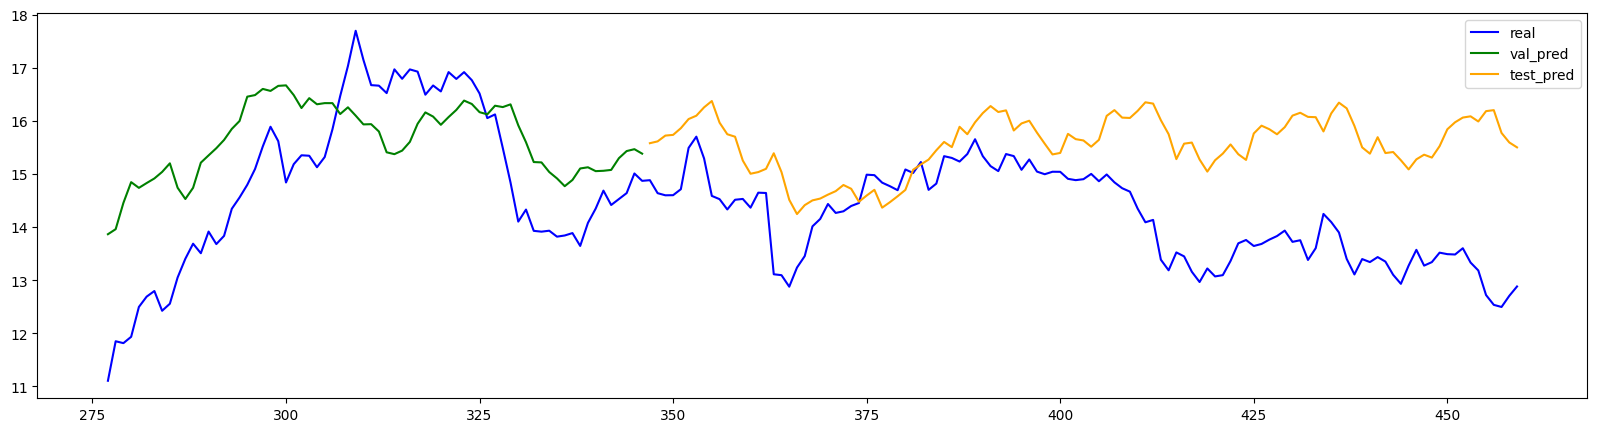

Epoch 1/1000
12/12 [==============================] - 1s 34ms/step - loss: 0.0295 - val_loss: 0.0036
Epoch 2/1000
12/12 [==============================] - 0s 25ms/step - loss: 0.0232 - val_loss: 0.0018
Epoch 3/1000
12/12 [==============================] - 0s 24ms/step - loss: 0.0185 - val_loss: 0.0014
Epoch 4/1000
12/12 [==============================] - 0s 25ms/step - loss: 0.0150 - val_loss: 0.0018
Epoch 5/1000
12/12 [==============================] - 0s 26ms/step - loss: 0.0125 - val_loss: 0.0026
Epoch 6/1000
12/12 [==============================] - 0s 24ms/step - loss: 0.0107 - val_loss: 0.0034
Epoch 7/1000
12/12 [==============================] - 0s 24ms/step - loss: 0.0095 - val_loss: 0.0041
Epoch 8/1000
12/12 [==============================] - 0s 24ms/step - loss: 0.0085 - val_loss: 0.0045
Epoch 9/1000
12/12 [==============================] - 0s 24ms/step - loss: 0.0078 - val_loss: 0.0046
Epoch 10/1000
12/12 [==============================] - 0s 24ms/step - loss: 0.0072 - val_lo

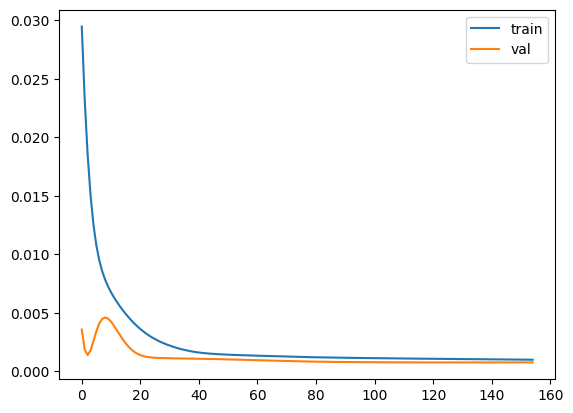

4/4 [==============================] - 0s 3ms/step
train mae: 2.8878108243548635
val mae: 0.43575454554350485


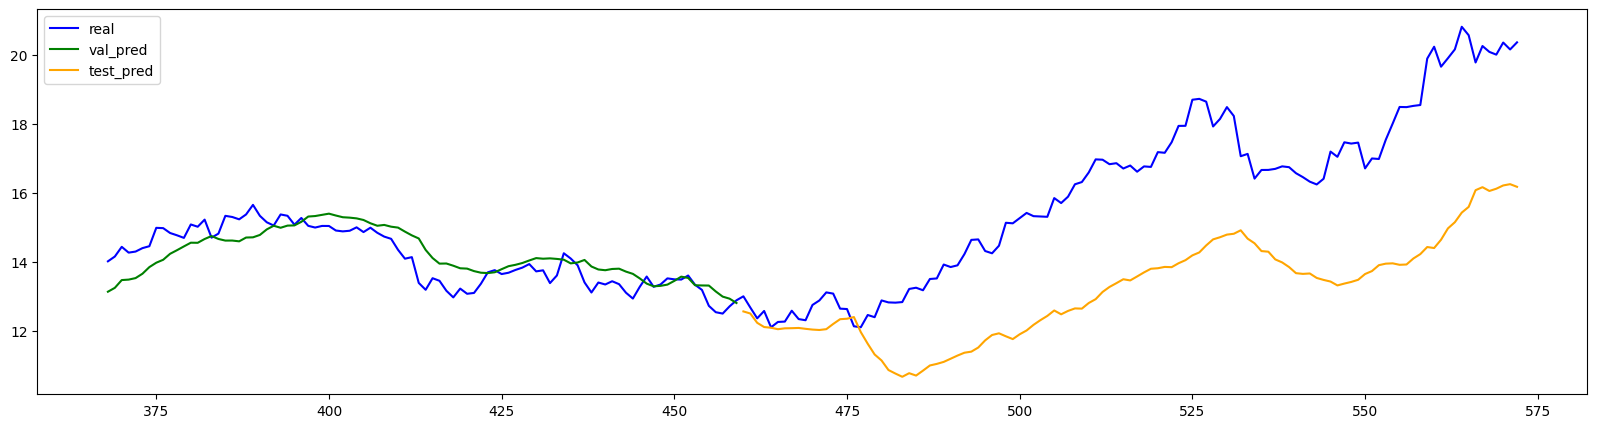

Epoch 1/1000
15/15 [==============================] - 2s 35ms/step - loss: 0.0339 - val_loss: 0.0434
Epoch 2/1000
15/15 [==============================] - 0s 24ms/step - loss: 0.0274 - val_loss: 0.0356
Epoch 3/1000
15/15 [==============================] - 0s 25ms/step - loss: 0.0224 - val_loss: 0.0296
Epoch 4/1000
15/15 [==============================] - 0s 26ms/step - loss: 0.0186 - val_loss: 0.0254
Epoch 5/1000
15/15 [==============================] - 0s 26ms/step - loss: 0.0158 - val_loss: 0.0225
Epoch 6/1000
15/15 [==============================] - 0s 24ms/step - loss: 0.0139 - val_loss: 0.0205
Epoch 7/1000
15/15 [==============================] - 0s 24ms/step - loss: 0.0126 - val_loss: 0.0193
Epoch 8/1000
15/15 [==============================] - 0s 24ms/step - loss: 0.0117 - val_loss: 0.0183
Epoch 9/1000
15/15 [==============================] - 0s 26ms/step - loss: 0.0111 - val_loss: 0.0177
Epoch 10/1000
15/15 [==============================] - 0s 26ms/step - loss: 0.0106 - val_lo

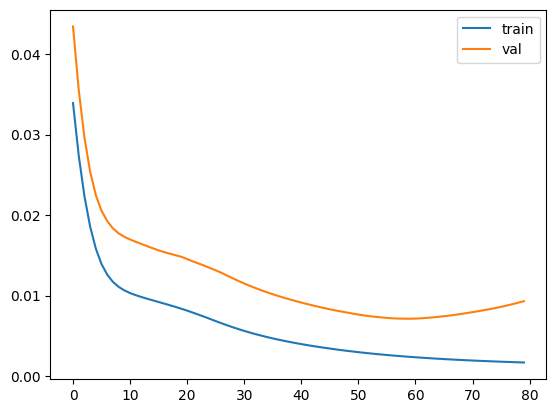

4/4 [==============================] - 0s 4ms/step
train mae: 5.594330580285537
val mae: 1.501333040361753


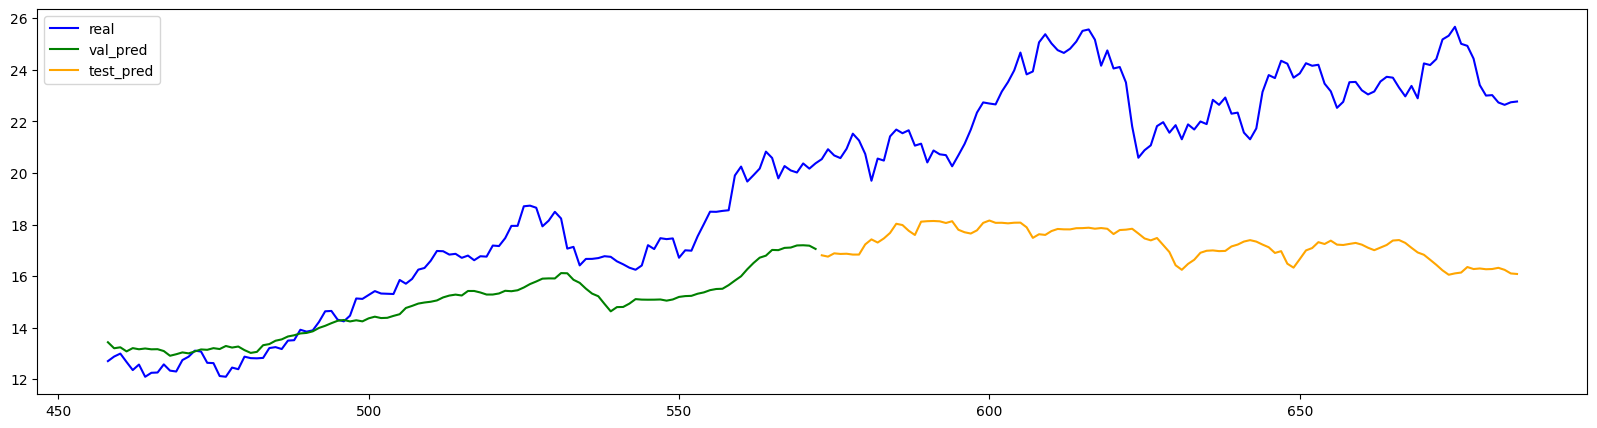

Epoch 1/1000
18/18 [==============================] - 4s 34ms/step - loss: 0.3128 - val_loss: 0.6345
Epoch 2/1000
18/18 [==============================] - 0s 25ms/step - loss: 0.2552 - val_loss: 0.5114
Epoch 3/1000
18/18 [==============================] - 0s 24ms/step - loss: 0.2074 - val_loss: 0.4084
Epoch 4/1000
18/18 [==============================] - 0s 25ms/step - loss: 0.1675 - val_loss: 0.3225
Epoch 5/1000
18/18 [==============================] - 0s 26ms/step - loss: 0.1343 - val_loss: 0.2512
Epoch 6/1000
18/18 [==============================] - 0s 27ms/step - loss: 0.1068 - val_loss: 0.1923
Epoch 7/1000
18/18 [==============================] - 0s 26ms/step - loss: 0.0840 - val_loss: 0.1444
Epoch 8/1000
18/18 [==============================] - 0s 25ms/step - loss: 0.0654 - val_loss: 0.1061
Epoch 9/1000
18/18 [==============================] - 0s 25ms/step - loss: 0.0505 - val_loss: 0.0762
Epoch 10/1000
18/18 [==============================] - 0s 26ms/step - loss: 0.0389 - val_lo

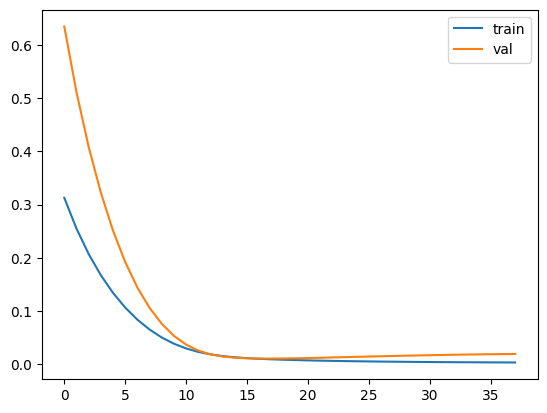

4/4 [==============================] - 0s 6ms/step
train mae: 3.489265520023852
val mae: 2.238566056115192


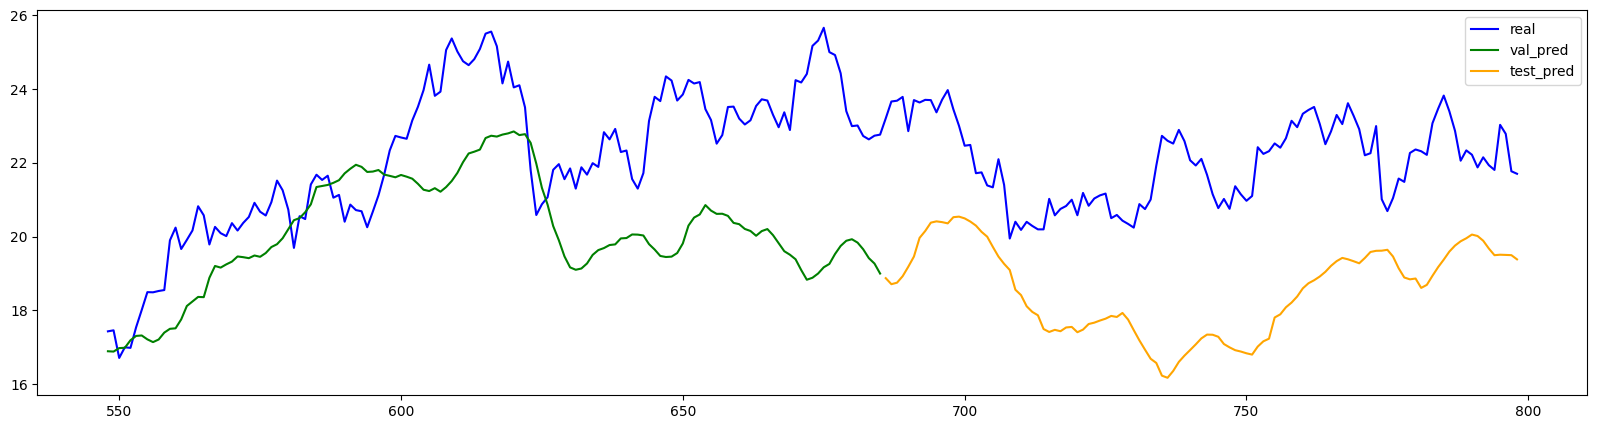

Epoch 1/1000
20/20 [==============================] - 2s 29ms/step - loss: 0.0726 - val_loss: 0.0261
Epoch 2/1000
20/20 [==============================] - 0s 24ms/step - loss: 0.0409 - val_loss: 0.0104
Epoch 3/1000
20/20 [==============================] - 0s 24ms/step - loss: 0.0262 - val_loss: 0.0116
Epoch 4/1000
20/20 [==============================] - 0s 24ms/step - loss: 0.0198 - val_loss: 0.0161
Epoch 5/1000
20/20 [==============================] - 0s 24ms/step - loss: 0.0163 - val_loss: 0.0189
Epoch 6/1000
20/20 [==============================] - 0s 24ms/step - loss: 0.0139 - val_loss: 0.0200
Epoch 7/1000
20/20 [==============================] - 0s 23ms/step - loss: 0.0121 - val_loss: 0.0203
Epoch 8/1000
20/20 [==============================] - 0s 24ms/step - loss: 0.0105 - val_loss: 0.0203
Epoch 9/1000
20/20 [==============================] - 0s 24ms/step - loss: 0.0092 - val_loss: 0.0204
Epoch 10/1000
20/20 [==============================] - 0s 24ms/step - loss: 0.0080 - val_lo

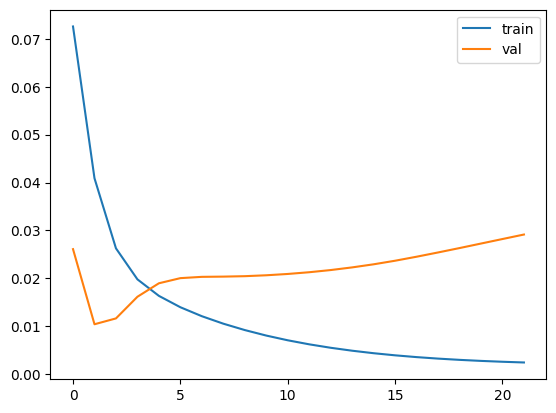

4/4 [==============================] - 0s 3ms/step
train mae: 4.109221350863566
val mae: 2.708245935362244


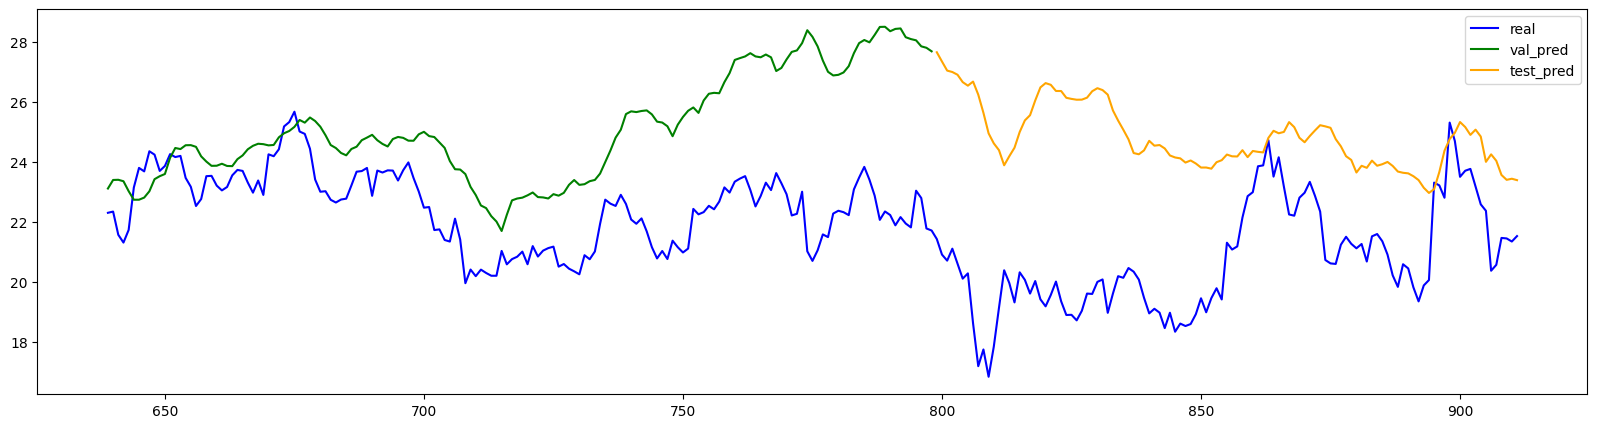

Epoch 1/1000
23/23 [==============================] - 2s 31ms/step - loss: 0.2567 - val_loss: 0.4448
Epoch 2/1000
23/23 [==============================] - 1s 27ms/step - loss: 0.1865 - val_loss: 0.3316
Epoch 3/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.1347 - val_loss: 0.2420
Epoch 4/1000
23/23 [==============================] - 1s 26ms/step - loss: 0.0957 - val_loss: 0.1707
Epoch 5/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.0667 - val_loss: 0.1151
Epoch 6/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.0461 - val_loss: 0.0739
Epoch 7/1000
23/23 [==============================] - 1s 28ms/step - loss: 0.0326 - val_loss: 0.0456
Epoch 8/1000
23/23 [==============================] - 1s 24ms/step - loss: 0.0246 - val_loss: 0.0282
Epoch 9/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.0202 - val_loss: 0.0187
Epoch 10/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.0179 - val_lo

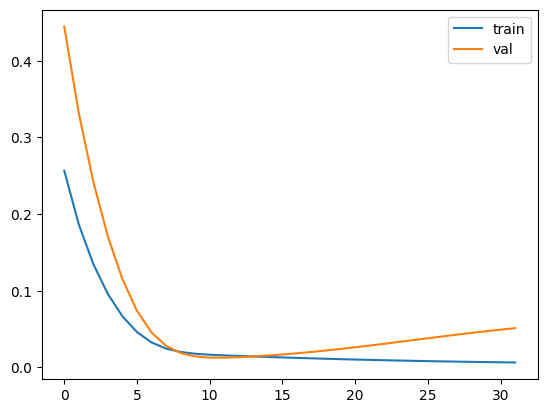

4/4 [==============================] - 0s 3ms/step
train mae: 8.578877984991832
val mae: 3.579016073337576


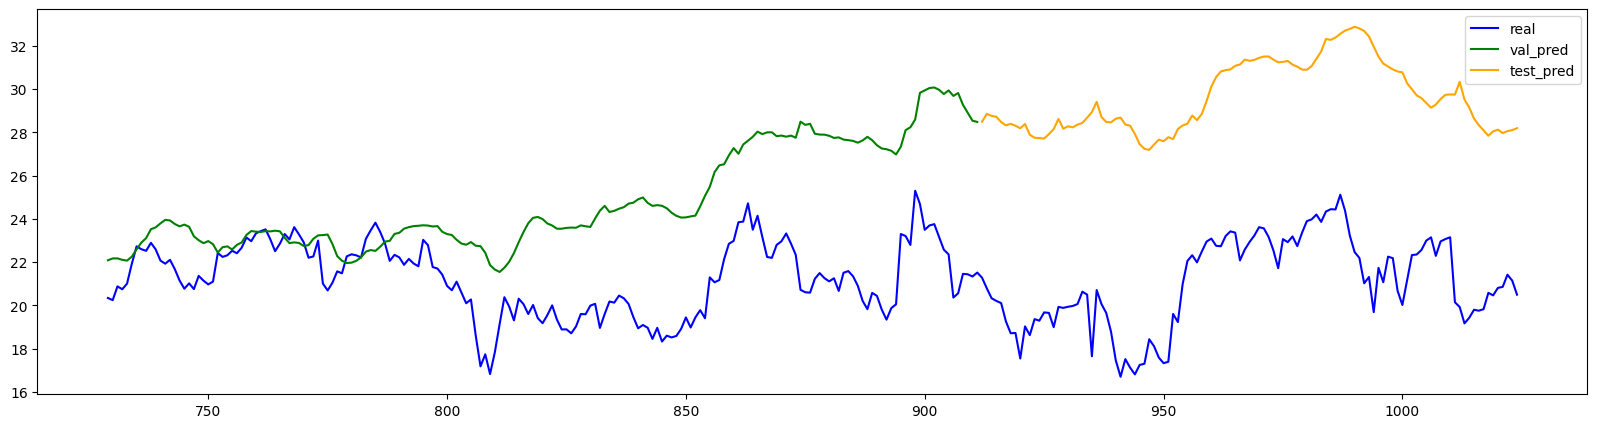

Epoch 1/1000
26/26 [==============================] - 2s 35ms/step - loss: 0.2367 - val_loss: 0.1348
Epoch 2/1000
26/26 [==============================] - 1s 26ms/step - loss: 0.1491 - val_loss: 0.0449
Epoch 3/1000
26/26 [==============================] - 1s 26ms/step - loss: 0.0906 - val_loss: 0.0094
Epoch 4/1000
26/26 [==============================] - 1s 27ms/step - loss: 0.0531 - val_loss: 0.0119
Epoch 5/1000
26/26 [==============================] - 1s 25ms/step - loss: 0.0313 - val_loss: 0.0362
Epoch 6/1000
26/26 [==============================] - 1s 25ms/step - loss: 0.0204 - val_loss: 0.0661
Epoch 7/1000
26/26 [==============================] - 1s 24ms/step - loss: 0.0156 - val_loss: 0.0897
Epoch 8/1000
26/26 [==============================] - 1s 24ms/step - loss: 0.0137 - val_loss: 0.1027
Epoch 9/1000
26/26 [==============================] - 1s 26ms/step - loss: 0.0128 - val_loss: 0.1066
Epoch 10/1000
26/26 [==============================] - 1s 24ms/step - loss: 0.0122 - val_lo

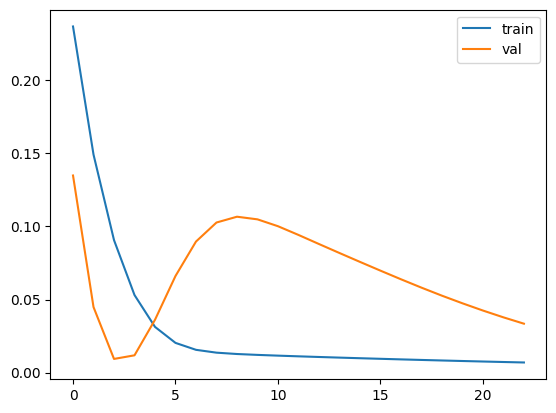

4/4 [==============================] - 0s 3ms/step
train mae: 2.925498703417752
val mae: 3.198932037267769


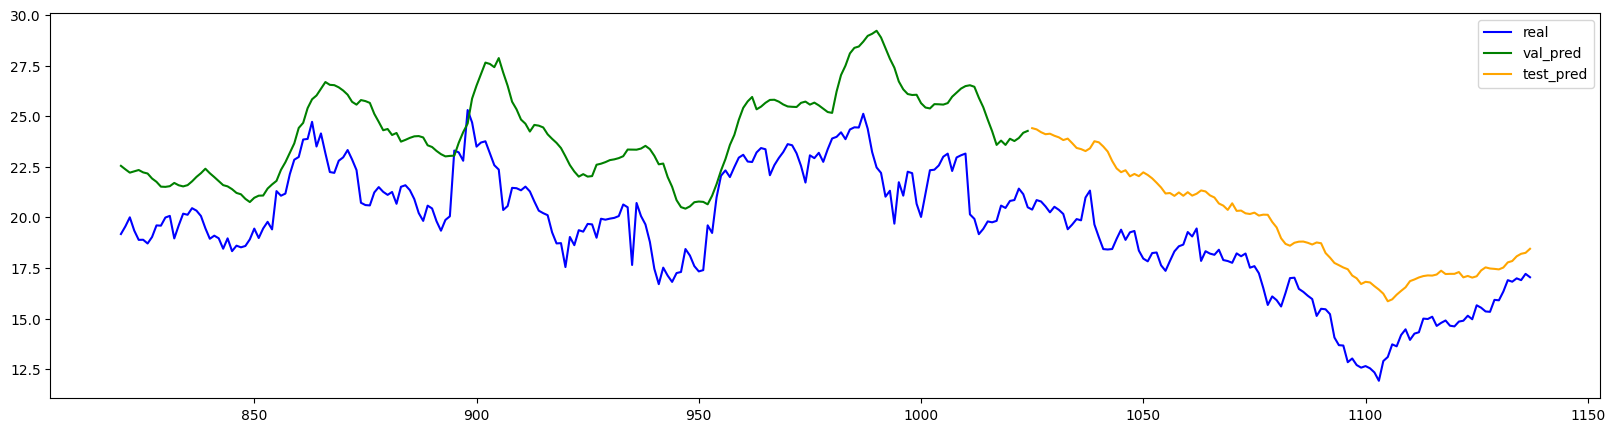

Epoch 1/1000
29/29 [==============================] - 2s 31ms/step - loss: 0.2994 - val_loss: 0.3081
Epoch 2/1000
29/29 [==============================] - 1s 25ms/step - loss: 0.2245 - val_loss: 0.2041
Epoch 3/1000
29/29 [==============================] - 1s 25ms/step - loss: 0.1685 - val_loss: 0.1278
Epoch 4/1000
29/29 [==============================] - 1s 25ms/step - loss: 0.1244 - val_loss: 0.0737
Epoch 5/1000
29/29 [==============================] - 1s 25ms/step - loss: 0.0903 - val_loss: 0.0395
Epoch 6/1000
29/29 [==============================] - 1s 25ms/step - loss: 0.0645 - val_loss: 0.0227
Epoch 7/1000
29/29 [==============================] - 1s 25ms/step - loss: 0.0458 - val_loss: 0.0205
Epoch 8/1000
29/29 [==============================] - 1s 26ms/step - loss: 0.0336 - val_loss: 0.0288
Epoch 9/1000
29/29 [==============================] - 1s 26ms/step - loss: 0.0266 - val_loss: 0.0416
Epoch 10/1000
29/29 [==============================] - 1s 24ms/step - loss: 0.0227 - val_lo

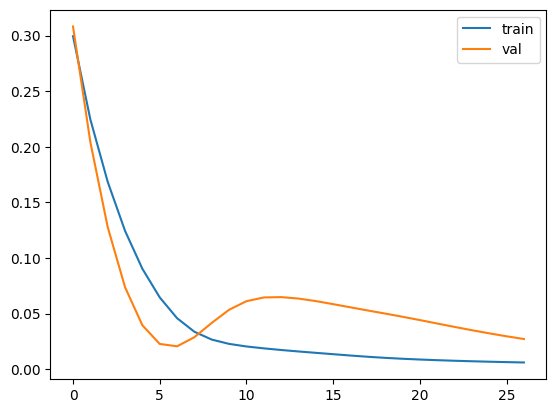

4/4 [==============================] - 0s 3ms/step
train mae: 1.6794992970283984
val mae: 2.7129308892340416


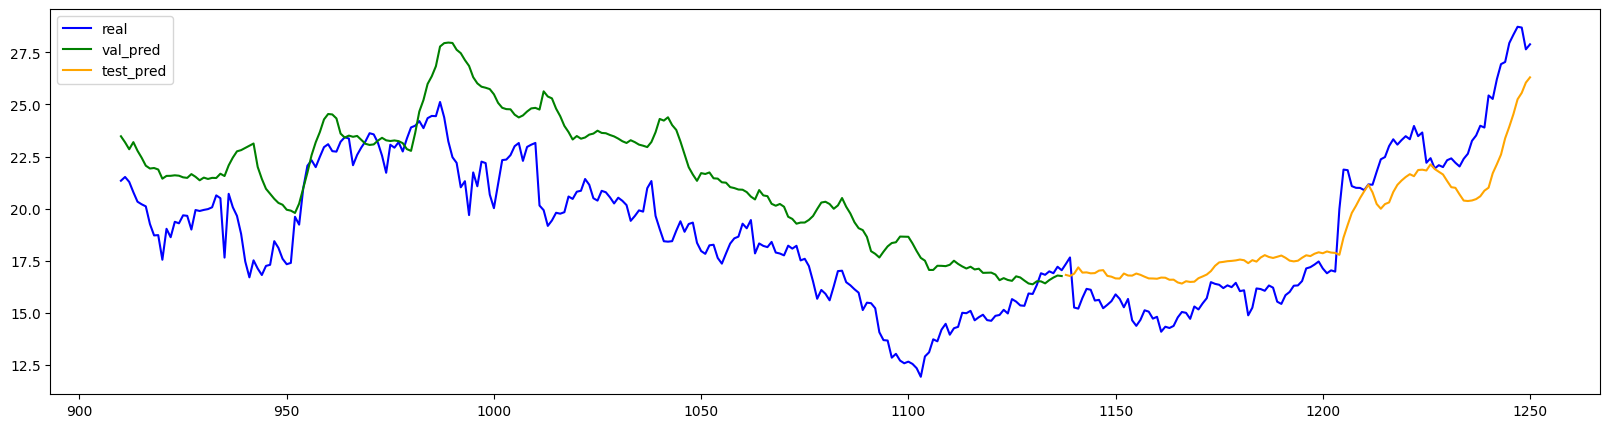

In [67]:
tscv = TimeSeriesSplit(n_splits=10)
t_maes=[]
v_maes=[]
for train_index, test_index in tscv.split(X):
    X_tmp, X_test = X[train_index], X[test_index]
    y_tmp, y_test= y[train_index], y[test_index]
    val_split = int(len(train_index) * 0.8)  # Adjust the validation split percentage as needed
    X_train, x_val = X_tmp[:val_split], X_tmp[val_split:]
    y_train, y_val = y_tmp[:val_split], y_tmp[val_split:]

    model=model = tuner.hypermodel.build(best_hps)
    history=model.fit(X_train,y_train,epochs=1000,validation_data=(x_val,y_val),shuffle=False, callbacks=[early_stop])
    plt.plot(history.history['loss'],label='train')
    plt.plot(history.history['val_loss'],label='val')
    plt.legend()
    plt.show()

    y_test=np.repeat(y_test,X.shape[2],axis=1)
    y_test=scaler.inverse_transform(y_test)[:,-1] 
    y_val=np.repeat(y_val,X.shape[2],axis=1)
    y_val=scaler.inverse_transform(y_val)[:,-1]

    y_val_pred=model.predict(x_val)
    val_pred=np.repeat(y_val_pred,X.shape[2],axis=1)
    val_pred=scaler.inverse_transform(val_pred)[:,-1]

    y_pred=model.predict(X_test)
    pred=np.repeat(y_pred,X_train.shape[2],axis=1)
    pred=scaler.inverse_transform(pred)[:,-1]
    
    v_time=range(X_train.shape[0],X_train.shape[0]+len(y_val))

    t_time=range(X_train.shape[0]+len(y_val),X_train.shape[0]+len(y_val)+len(y_test))

    r_time=range(X_train.shape[0],X_train.shape[0]+len(y_val)+len(y_test))

    t_mae=np.mean(np.abs(pred-y_test))
    t_maes.append(t_mae)
    print('train mae:',t_mae)
    v_mae=np.mean(np.abs(val_pred-y_val))
    v_maes.append(v_mae)
    print('val mae:',v_mae)

    #plotting the results
    real=np.concatenate((y_val,y_test))
    plt.figure(figsize=(20,5))
    plt.plot(r_time,real,label='real',color='blue')
    plt.plot(v_time,val_pred,label='val_pred',color='green')
    plt.plot(t_time,pred, label='test_pred',color='orange') 
    plt.legend()
    plt.show()


In [68]:
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_29 (Bidirect  (None, 40)                6080      
 ional)                                                          
                                                                 
 dense_29 (Dense)            (None, 1)                 41        
                                                                 
Total params: 6121 (23.91 KB)
Trainable params: 6121 (23.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [69]:
Taverage_mae=np.mean(t_maes)

print('Average MAE in testing:',Taverage_mae)

Vaverage_mae=np.mean(v_maes)

print('Average MAE in validation:',Vaverage_mae)

Average MAE in testing: 3.461211111036561
Average MAE in validation: 2.0440488965774897
